<a href="https://colab.research.google.com/github/AaravM11/NLP_Research/blob/main/Bag_SVM_Criticism_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages, data loading

import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn import preprocessing

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score

df = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/chatgpt.csv")


df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [ ]:
# clean the tweets

tweets = df["tweets"].values
cleaned_tweets = []

import re

for tweet in tweets:
  tweet2 = re.sub(r'^RT[\s]+', '', tweet)
  tweet2 = re.sub('http://\S+|https://\S+', '', tweet2)
  tweet2 = re.sub('http[s]?://\S+', '', tweet2)
  tweet2 = re.sub(r"http\S+", "", tweet2)
  tweet2 = re.sub(r'#', '', tweet2)
  cleaned_tweets.append(tweet2)

for i in range(len(tweets)):
  tweets[i] = cleaned_tweets[i]

original_tweets = tweets


In [ ]:
# initialize criticism phrases

criticism_phrases = [
    "Not convinced by",
    "Vulnerable to criticism",
    "Disapprove of",
    "Take a critical stance on",
    "Not impressed",
    "Meh",
    "Disappointed",
    "Not cool",
    "Not buying it",
    "Seriously?",
    "Not okay",
    "Kinda sketchy",
    "Raise an eyebrow",
    "Not feeling it",
    "Not a fan",
    "Eh, nope",
    "Bit of a letdown",
    "Questionable move",
    "Hmm, doubtful",
    "Skeptical about",
    "Lacking substance",
    "Seems off",
    "Could do better",
    "Expected more",
    "Unimpressive",
    "Flimsy excuse",
    "Not quite there",
    "Bit underwhelming",
    "Not sold on this",
    "Seems fishy",
    "Missed the mark",
    "Not vibing with",
    "Bit of a fail",
    "Didn't hit home",
    "However",
    "Unfortunately",
    "Flaw",
    "Issue",
    "Problematic",
    "Concerning",
    "Inadequate",
    "Lack",
    "Mistake",
    "Weakness",
    "Failure",
    "Shortcoming",
    "Not up to par",
    "Falls short",
    "Disappointing",
    "Unsatisfactory",
    "Fault",
    "Critique",
    "Condemn",
    "Object",
    "Dissatisfying",
    "Underwhelming",
    "Not well-executed",
    "Questionable",
    "Criticize",
    "Challenge",
    "Rebuke",
    "Negative aspect",
    "Drawback",
    "Debatable",
    "Criticism",
    "Censure",
    "Knock",
    "Denounce",
    "Faultfinding",
    "Reprove",
    "Upbraiding",
    "Reprimand",
    "Blame",
    "Reproach",
    "Chide",
    "Attack",
    "Nitpick",
    "Find fault with",
    "Take issue with",
    "Object to",
    "Complain about",
    "Berate",
    "Castigate",
    "Decry"
]

In [ ]:
# empty criticism labels array

criticism_labels = np.empty(df.shape[0], dtype=object)
criticism_labels


array([None, None, None, ..., None, None, None], dtype=object)

In [ ]:
# tokenizing all the samples

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

for i in range(len(tweets)):
  tweets[i] = word_tokenize(tweets[i])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(criticism_phrases[0])

Not convinced by


In [ ]:
# tokenizing all the of the criticism phrases

for i in range(len(criticism_phrases)):
  criticism_phrases[i] = word_tokenize(criticism_phrases[i])


criticism_phrases

[['Not', 'convinced', 'by'],
 ['Vulnerable', 'to', 'criticism'],
 ['Disapprove', 'of'],
 ['Take', 'a', 'critical', 'stance', 'on'],
 ['Not', 'impressed'],
 ['Meh'],
 ['Disappointed'],
 ['Not', 'cool'],
 ['Not', 'buying', 'it'],
 ['Seriously', '?'],
 ['Not', 'okay'],
 ['Kinda', 'sketchy'],
 ['Raise', 'an', 'eyebrow'],
 ['Not', 'feeling', 'it'],
 ['Not', 'a', 'fan'],
 ['Eh', ',', 'nope'],
 ['Bit', 'of', 'a', 'letdown'],
 ['Questionable', 'move'],
 ['Hmm', ',', 'doubtful'],
 ['Skeptical', 'about'],
 ['Lacking', 'substance'],
 ['Seems', 'off'],
 ['Could', 'do', 'better'],
 ['Expected', 'more'],
 ['Unimpressive'],
 ['Flimsy', 'excuse'],
 ['Not', 'quite', 'there'],
 ['Bit', 'underwhelming'],
 ['Not', 'sold', 'on', 'this'],
 ['Seems', 'fishy'],
 ['Missed', 'the', 'mark'],
 ['Not', 'vibing', 'with'],
 ['Bit', 'of', 'a', 'fail'],
 ['Did', "n't", 'hit', 'home'],
 ['However'],
 ['Unfortunately'],
 ['Flaw'],
 ['Issue'],
 ['Problematic'],
 ['Concerning'],
 ['Inadequate'],
 ['Lack'],
 ['Mistake'],
 

In [ ]:
# stemming criticism phrases

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

stemmed_tweets = []
for tweet in criticism_phrases:
  stemmed_tweet = []
  for word in tweet:
    new_word = stemmer.stem(word)
    stemmed_tweet.append(new_word)
  stemmed_tweets.append(stemmed_tweet)

for i in range(len(criticism_phrases)):
  criticism_phrases[i] = stemmed_tweets[i]

In [ ]:
# stemming all the samples

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

stemmed_tweets = []
for tweet in tweets:
  stemmed_tweet = []
  for word in tweet:
    new_word = stemmer.stem(word)
    stemmed_tweet.append(new_word)
  stemmed_tweets.append(stemmed_tweet)

for i in range(len(tweets)):
  tweets[i] = stemmed_tweets[i]

In [ ]:
print(tweets)
print(criticism_phrases)

[list(['chatgpt', ':', 'optim', 'languag', 'model', 'for', 'dialogu', '@', 'openai'])
 list(['tri', 'talk', 'with', 'chatgpt', ',', 'our', 'new', 'ai', 'system', 'which', 'is', 'optim', 'for', 'dialogu', '.', 'your', 'feedback', 'will', 'help', 'us', 'improv', 'it', '.'])
 list(['chatgpt', ':', 'optim', 'languag', 'model', 'for', 'dialogu', 'ai', 'machinelearn', 'datasci', 'artificialintelligence\\n\\ntrend', 'ai/ml', 'articl', 'identifi', '&', 'amp', ';', 'digest', 'via', 'granola', ';', 'a', 'machine-driven', 'rss', 'bot', 'by', 'ramsey', 'elbash'])
 ...
 list(['chatgpt', 'is', 'be', 'disassembl', 'until', 'it', 'can', 'onli', 'dissembl'])
 list(['2023', 'predict', 'by', 'chatgpt', '.', 'noth', 'realli', 'specif', ',', 'just', 'some', 'trend', 'from', 'the', 'past', 'year', '.', '\\nshould', 'be', 'around', 'thi', 'topic', ',', 'we', 'will', 'see', 'in', '364', 'day', '🎉'])
 list(['from', 'chatgpt', ',', 'neat', 'stuff'])]
[['not', 'convinc', 'by'], ['vulner', 'to', 'critic'], ['disa

In [ ]:
# detokenizing all the samples

from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenizer = TreebankWordDetokenizer()

for i in range(len(tweets)):
  tweets[i] = detokenizer.detokenize(tweets[i])

In [ ]:
# detokenizing all the criticism phrases

for i in range(len(criticism_phrases)):
  criticism_phrases[i] = detokenizer.detokenize(criticism_phrases[i])

In [ ]:
print(tweets)
print(criticism_phrases)

['chatgpt: optim languag model for dialogu @ openai'
 'tri talk with chatgpt, our new ai system which is optim for dialogu . your feedback will help us improv it.'
 'chatgpt: optim languag model for dialogu ai machinelearn datasci artificialintelligence\\n\\ntrend ai/ml articl identifi & amp; digest via granola; a machine-driven rss bot by ramsey elbash'
 ... 'chatgpt is be disassembl until it can onli dissembl'
 '2023 predict by chatgpt . noth realli specif, just some trend from the past year . \\nshould be around thi topic, we will see in 364 day 🎉'
 'from chatgpt, neat stuff']
['not convinc by', 'vulner to critic', 'disapprov of', 'take a critic stanc on', 'not impress', 'meh', 'disappoint', 'not cool', 'not buy it', 'serious?', 'not okay', 'kinda sketchi', 'rais an eyebrow', 'not feel it', 'not a fan', 'eh, nope', 'bit of a letdown', 'question move', 'hmm, doubt', 'skeptic about', 'lack substanc', 'seem off', 'could do better', 'expect more', 'unimpress', 'flimsi excus', 'not quit 

In [ ]:
# initializing criticism array labels

new_criticism_labels = []

for i in range(len(criticism_labels)):
    found = False

    for phrase in criticism_phrases:
        if phrase in tweets[i]:
            new_criticism_labels.append(1)
            found = True
            break

    if not found:
        new_criticism_labels.append(0)
criticism_labels = new_criticism_labels

print(len(criticism_labels))

219294


In [ ]:
print(len(criticism_labels))

219294


[link text](`https://`)

In [ ]:
tweets = original_tweets

In [ ]:
# tokenizing all the samples

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

for i in range(len(tweets)):
  tweets[i] = word_tokenize(tweets[i])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# importing stopwords

nltk.download("stopwords")
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# removing stop words

stop = set(stopwords.words('english'))
print(stop)
new_tweets = tweets
new_tweets2 = []
for tweet in new_tweets:
  new_tweet = []
  for word in tweet:
    if (word not in stop and word not in string.punctuation):
      new_tweet.append(word)
  new_tweets2.append(new_tweet)


for i in range(len(tweets)):
  tweets[i] = new_tweets2[i]

{'all', 'mustn', 'than', 'himself', 'during', 'if', 'were', 'will', 'their', 'about', 'and', 'aren', 'haven', 'yours', 'she', 'does', 'such', 'no', 'where', 'am', 'while', 'weren', "you're", "you'll", 'in', 'until', 'be', 'just', 'own', 'had', "don't", 'is', 'me', "aren't", 'herself', 'against', 'above', 'why', "should've", "didn't", 'doing', 'into', 'i', 'you', 'have', 'my', "needn't", 'same', 'hasn', 'on', 'other', 'hers', 'too', 'needn', "hasn't", 'them', 'm', 'yourselves', 'we', 'to', 'as', 'did', "that'll", 'these', 'ma', 'over', "you've", 'an', "mustn't", 'with', 'our', 'out', "wasn't", 'are', 'd', 'again', 'isn', 'mightn', 'her', 'a', 'wasn', 'up', 'didn', 'both', 'under', 'shan', 'ain', 'shouldn', 'won', 're', 'at', 'some', 'couldn', 'for', "shouldn't", 'his', 'but', 'nor', "won't", 'that', "doesn't", 'whom', 'myself', "it's", 'him', 'do', 'through', 'here', 'who', 'he', 'by', 'll', 'doesn', 'your', 'those', 'further', 'because', 'how', 'this', "mightn't", 'so', 'more', 'what',

In [ ]:
# stemming all the samples

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

stemmed_tweets = []
for tweet in tweets:
  stemmed_tweet = []
  for word in tweet:
    new_word = stemmer.stem(word)
    stemmed_tweet.append(new_word)
  stemmed_tweets.append(stemmed_tweet)

for i in range(len(tweets)):
  tweets[i] = stemmed_tweets[i]

In [ ]:
def build_freqs(tweets, labels):
  freqs = {}
  for i in range(len(labels)):
    for word in tweets[i]:
      pair = (word, labels[i])
      if pair in freqs:
        freqs[pair] += 1
      else:
          freqs[pair] = 1
  return freqs


In [ ]:
freqs = build_freqs(tweets, criticism_labels)

In [ ]:
X = np.zeros((len(tweets), 2))

In [ ]:
def features(tweets,freqs):
  for i in range(len(tweets)):
    tweet = tweets[i]
    for w in tweet:
      if (w, 0) in freqs:
        X[i, 0] = X[i, 0] + freqs[(w, 0)]
      if (w, 1) in freqs:
        X[i, 1] = X[i, 1] + freqs[(w, 1)]
  return X

In [ ]:
X = features(tweets, freqs)

In [ ]:
y = criticism_labels
y = np.array(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = .25, random_state = 4)

In [ ]:
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

In [ ]:
#Encoder = LabelEncoder()
#Train_Y = Encoder.fit_transform(y_train)
#Val_Y = Encoder.fit_transform(y_val)

In [ ]:
from sklearn.svm import SVC

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_scaled,y_train)

predictions_SVM = SVM.predict(X_val_scaled)

print("Accuracy: ",accuracy_score(predictions_SVM, y_val)*100)

Accuracy:  94.85079527214359


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(predictions_SVM, y_val))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     52298
           1       0.47      0.89      0.62      2526

    accuracy                           0.95     54824
   macro avg       0.73      0.92      0.79     54824
weighted avg       0.97      0.95      0.96     54824



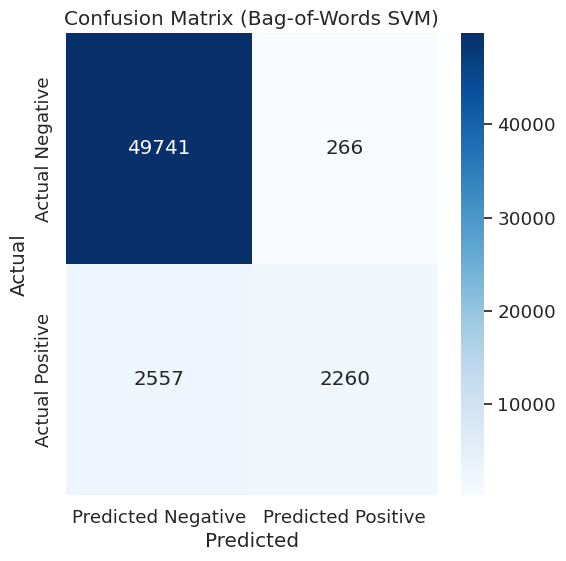

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, predictions_SVM)

# Set up the figure and axes
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Bag-of-Words SVM)")

plt.show()